In [1]:
import time

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# fix random seeds
rng_seed = 0
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)

from xopt import Xopt
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import ExpectedImprovementGenerator, UpperConfidenceBoundGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.torch import LUMEModule

from utils import NegativeTransverseBeamSize
from utils import load_surrogate, load_corr_model, create_vocs, print_runtime, running_max
from dynamic_custom_mean import DynamicCustomMean, Flatten, OccasionalConstant, OccasionalModel

In [2]:
# define prior mean
mean_class = DynamicCustomMean
mean_kwargs = {}
n_epoch = 10  # determines which correlated model is used

# define acquisition function
acq_name = "EI"  # "EI" or "UCB"

In [3]:
# load surrogate model and define objective
surrogate = load_surrogate("configs/lcls_variables.yml", "configs/normalization.json", "torch_model.pt")
objective_name = "negative_sigma_xy"
vocs = create_vocs(surrogate, objective_name)
surrogate_module = LUMEModule(surrogate, vocs.variable_names, ["sigma_x", "sigma_y"])
Objective = NegativeTransverseBeamSize
ground_truth = Objective(surrogate_module)

# Xopt evaluator function
def evaluate(input_dict):
    model_result = surrogate.evaluate(input_dict)
    obj_kwargs = {key:model_result[key] for key in surrogate_module.output_order}
    obj_value = Objective.function(**obj_kwargs).detach().item()
    return {objective_name: obj_value}

In [4]:
# load correlated model
corr_model = load_corr_model(
    "configs/lcls_variables.yml",
    "corr_models/x_transformer.pt",
    "corr_models/y_transformer.pt",
    "corr_models/{:d}ep.pt".format(n_epoch)
)
corr_module = LUMEModule(corr_model, vocs.variable_names, ["sigma_x", "sigma_y"])
mean_kwargs["model"] = Objective(corr_module)

In [5]:
# generate initial data set
n_init = 3
inputs_init = pd.DataFrame(vocs.random_inputs(n=n_init, seed=rng_seed))
outputs = [evaluate(inputs_init.to_dict(orient="index")[i])[objective_name] for i in range(n_init)]
outputs_init = pd.DataFrame({objective_name: outputs})
data_init = pd.concat([inputs_init, outputs_init], axis=1)
data_init

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,negative_sigma_xy
0,0.315416,11.849845,0.218563,-0.008702,-0.007148,3.845480,-0.490601,3.625577,-2.844318,1.115676,-4.508010,-4.770960,4.084017,250.0,58000000.0,70000000.0,-2.673201
1,0.421819,4.680301,0.210919,-0.006318,0.009328,-20.211281,-4.794569,1.987560,-2.153845,2.887162,-2.112335,-3.202335,1.662885,250.0,58000000.0,70000000.0,-1.464008
2,0.488126,3.785076,0.222483,0.009938,-0.004593,-8.954229,9.007755,2.057821,-3.982130,3.097626,-0.082182,-1.481926,1.395637,250.0,58000000.0,70000000.0,-2.367977


In [6]:
# run BO
n_step = 50
t0 = time.time()

# define dynamic custom mean
mean_kwargs["step"] = 0
model_constructor = StandardModelConstructor(
    mean_modules={objective_name: mean_class(**mean_kwargs)},
    trainable_mean_keys=[objective_name],
)

# Xopt definition
numerical_optimizer = LBFGSOptimizer(n_restarts=5, n_raw_samples=20)
generator_lookup = {"EI": ExpectedImprovementGenerator, "UCB": UpperConfidenceBoundGenerator}
generator = generator_lookup[acq_name](
    vocs=vocs,
    model_constructor=model_constructor,
    numerical_optimizer=numerical_optimizer,
)
evaluator = Evaluator(function=evaluate)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs, data=data_init)

for i_step in range(n_step):
    # update dynamic custom mean
    mean_kwargs["step"] = i_step
    X.generator.model_constructor.mean_modules[objective_name] = mean_class(**mean_kwargs)
    # optimization step
    X.step()

# print runtime
print_runtime(t0, time.time())

Runtime: 3.11 min


In [7]:
# print data set
X.data

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,negative_sigma_xy,xopt_runtime,xopt_error
1,0.315416,11.849845,0.218563,-0.008702,-0.007148,3.845480,-0.490601,3.625577,-2.844318,1.115676,-4.508010,-4.770960,4.084017,250.0,58000000.0,70000000.0,-2.673201,NaN,NaN
2,0.421819,4.680301,0.210919,-0.006318,0.009328,-20.211281,-4.794569,1.987560,-2.153845,2.887162,-2.112335,-3.202335,1.662885,250.0,58000000.0,70000000.0,-1.464008,NaN,NaN
3,0.488126,3.785076,0.222483,0.009938,-0.004593,-8.954229,9.007755,2.057821,-3.982130,3.097626,-0.082182,-1.481926,1.395637,250.0,58000000.0,70000000.0,-2.367977,NaN,NaN
4,0.500000,8.558169,0.220151,0.009993,0.009299,-4.525949,-8.080647,3.153149,-1.110026,3.186174,-3.209922,-2.529892,1.253117,250.0,58000000.0,70000000.0,-0.984665,0.000601,False
5,0.499712,11.542417,0.234135,-0.000773,0.002796,-11.056125,8.892752,1.822309,-2.739523,3.176731,-2.018845,-5.357575,5.362612,250.0,58000000.0,70000000.0,-0.130855,0.000558,False
6,0.500000,7.911865,0.225734,-0.010000,-0.009999,-21.189239,8.849930,1.807918,-3.078077,2.473185,-1.230262,-2.988236,2.671237,250.0,58000000.0,70000000.0,-0.412360,0.000528,False
7,0.500000,10.559917,0.234888,-0.010000,0.009618,-9.373795,-24.318795,3.160128,-3.111511,1.975883,-0.761731,-3.041929,2.147218,250.0,58000000.0,70000000.0,-0.343478,0.000629,False
8,0.499999,11.331959,0.229387,0.007296,-0.009997,1.299339,-11.062039,3.648493,-3.418068,4.373521,-3.829591,-1.894857,2.427044,250.0,58000000.0,70000000.0,-0.223450,0.000536,False
9,0.499378,6.849755,0.227064,-0.004577,-0.009999,0.681060,-21.814298,3.160930,-3.521204,1.967577,-1.350310,-4.564709,3.851118,250.0,58000000.0,70000000.0,-0.539765,0.000627,False
10,0.500000,8.623747,0.233656,0.009993,0.009999,-6.172019,-13.589161,2.593171,-2.967136,2.294797,-1.617260,-3.846319,3.948609,250.0,58000000.0,70000000.0,-0.262726,0.000592,False


In [8]:
x_optimum = X.generator.get_optimum()
y_optimum = pd.DataFrame(evaluate(x_optimum.to_dict("index")[0]), index=[0])
y_optimum

,negative_sigma_xy
0,-0.282319


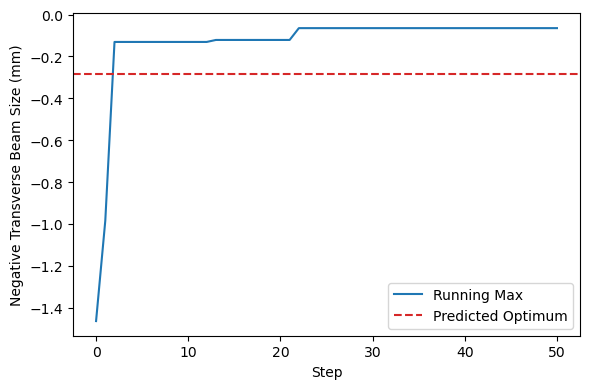

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x = torch.arange(n_step + 1)
y = torch.from_numpy(X.data[objective_name].values)
ax.plot(x, running_max(y.squeeze())[n_init - 1:], "C0-", label="Running Max")
ax.axhline(y=y_optimum[objective_name][0], color="C3", linestyle="--", label="Predicted Optimum")
ax.set_xlabel("Step")
ax.set_ylabel("{} ({})".format(ground_truth.name, ground_truth.unit))
ax.legend()
fig.tight_layout()